# EDA (Exploratory Data Analysis)

In this notebook I explore the data visually and try to pick out some insights from the data.

## Notes
### Outliers and Visualisation
Most plots of model loss are truncated since there are a number of massive outliers that make the interesting parts of the data hard to see (esp. when using the ReLU activation with a high learning rate).

### Incomparability of Regression and Classification Task Results
Since the regression tasks and classification tasks use different metrics, it is hard to directly compare the performance of the models accross both tasks. This is due the use of Pearson's R and RMSE in regression, whereas log loss and accuracy are being used for classification. As such, I would believe it best to consider models doing regression separately from models classification.

### Invalidity of Scoring Metric for Regression Tasks
The scoring metric used for evaluating the regression type models was Pearson's Correlation Coefficient (PCC):
![Pearson's Correlation Coefficient](https://wikimedia.org/api/rest_v1/media/math/render/svg/2b9c2079a3ffc1aacd36201ea0a3fb2460dc226f)
Here $x$ would be the target labels and $y$ the predicted labels.

Due to the unfortunate combination of PCC with SGD and binary valued spaces, many of the scores produced for the regression based models are likely erroneous. This is largely due to small batch sizes producing unfortunate combinations of output labels. For example, in the XOR problem if using a batch size of two, one may encounter the pair of target labels 0 and 0 (with inputs of [0, 0] and [1, 1]). The outputs of course have a variance of zero and we get a demonator of zero (see the equation above). 

I thought it was a good idea to add a small value $\epsilon$ to the denominator so if the variance was zero I would not get a divide by zero error, and instead get a value very close to zero. Although, this may have been a bad idea in the end since more *'genuine'* PCC scores very close to zero would be indistinguishable from these erroneous zero PCC scores.

Another problem is that with SGD you process one training pattern at a time. This is problematic when it comes to evaluating the PCC since $\bar{x}=x$ and $\bar{y}=y$, therefore the numerator will equal zero.

Using the $R^2$ metric (a.k.a. the Coefficient of Determination) does not avoid these issues. So it remains unclear to me what would be a robust scoring metric for regression tasks (robust in the sense that it can handle single samples and zero variance).

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

In [3]:
os.getcwd()

'/home/anthony/420/notebooks'

In [4]:
df = pd.read_csv('../scripts/results_summary.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4536 entries, ce2406bc88ceda4e2fde96bf96fdd2d5 to 9591fefef4086cbf060bc6afdcee4eba
Columns: 168 entries, activation_func to val_loss_39
dtypes: bool(1), float64(163), int64(1), object(3)
memory usage: 5.8+ MB


In [10]:
df.describe()

,batch_size,gaussian_noise,learning_rate,momentum,train_loss_00,train_loss_01,train_loss_02,train_loss_03,train_loss_04,train_loss_05,...,val_loss_30,val_loss_31,val_loss_32,val_loss_33,val_loss_34,val_loss_35,val_loss_36,val_loss_37,val_loss_38,val_loss_39
count,4536.000000,4536.000000,4536.000000,4536.000000,4.469000e+03,4.465000e+03,4.474000e+03,4.460000e+03,4.468000e+03,4.480000e+03,...,1.291000e+03,1.291000e+03,1.291000e+03,1.293000e+03,1.284000e+03,1.289000e+03,1.286000e+03,1.287000e+03,1.285000e+03,1.288000e+03
mean,3.238095,0.036667,0.037000,0.466667,6.139973e+148,1.178551e+143,2.240893e+146,1.080856e+143,5.007608e+146,1.060628e+132,...,3.490164e+139,1.192571e+140,6.523714e+144,3.004334e+88,5.270054e+87,2.447946e+133,2.201866e+139,7.127668e+127,1.836580e+128,4.176261e+140
std,7.432443,0.044974,0.044704,0.368219,4.104608e+150,7.788403e+144,1.498695e+148,7.218305e+144,3.347240e+148,7.099082e+133,...,1.254033e+141,4.284966e+141,2.344002e+146,1.079347e+90,1.846660e+89,8.788773e+134,7.896076e+140,2.557036e+129,6.583569e+129,1.498806e+142
min,-1.000000,0.000000,0.001000,0.000000,3.878009e-12,1.887379e-15,6.075696e-14,1.249001e-15,2.439715e-14,7.771561e-16,...,1.205098e-02,4.532566e-03,4.032520e-03,8.639882e-07,2.478734e-02,9.347693e-04,1.913314e-02,1.281576e-02,3.864593e-03,1.995955e-02
25%,-1.000000,0.000000,0.001000,0.000000,2.304792e-01,2.317160e-01,2.297833e-01,2.342466e-01,2.307808e-01,2.303364e-01,...,1.340462e-01,1.338613e-01,1.409296e-01,1.371336e-01,1.328476e-01,1.330931e-01,1.354859e-01,1.379978e-01,1.337317e-01,1.374174e-01
50%,1.000000,0.010000,0.010000,0.500000,5.006268e-01,5.005960e-01,5.009687e-01,5.008767e-01,5.006290e-01,5.009712e-01,...,2.280760e-01,2.075429e-01,2.246615e-01,2.367095e-01,2.146115e-01,2.205804e-01,2.219849e-01,2.380792e-01,2.077034e-01,2.332943e-01
75%,2.000000,0.100000,0.100000,0.900000,6.950951e-01,6.948118e-01,6.947904e-01,6.948717e-01,6.953892e-01,6.954834e-01,...,3.588411e-01,3.450229e-01,3.522622e-01,3.709971e-01,3.579938e-01,3.465480e-01,3.506236e-01,3.654653e-01,3.506442e-01,3.557505e-01
max,32.000000,0.100000,0.100000,0.900000,2.743954e+152,5.203949e+146,1.002447e+150,4.820618e+146,2.237399e+150,4.751615e+135,...,4.505802e+142,1.539609e+143,8.422115e+147,3.881150e+91,6.615518e+90,3.155402e+136,2.831599e+142,9.173309e+130,2.360005e+131,5.379024e+143


In [11]:
df.head()

,activation_func,batch_size,clf_type,dataset,gaussian_noise,learning_rate,momentum,shuffle_batches,train_loss_00,train_loss_01,...,val_loss_30,val_loss_31,val_loss_32,val_loss_33,val_loss_34,val_loss_35,val_loss_36,val_loss_37,val_loss_38,val_loss_39
run_id,,,,,,,,,,,,,,,,,,,,,
ce2406bc88ceda4e2fde96bf96fdd2d5,LeakyReLU,1,MLPRegressor,xor,0.0,0.1,0.9,True,5.166794e-01,5.365412e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
745da0d20037327f586babfb38077b62,LeakyReLU,1,MLPRegressor,xor,0.0,0.1,0.9,False,4.087733e-01,1.385021e-10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aeeec51b4e4d9c885bd53d0de5c46b14,LeakyReLU,1,MLPRegressor,xor,0.0,0.1,0.5,True,3.247473e-01,4.423432e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a99a2a1ecd0377d4d4d5c47d3015771b,LeakyReLU,1,MLPRegressor,xor,0.0,0.1,0.5,False,6.579213e-01,3.202256e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a523da2d87ca23feb5411114cf717710,LeakyReLU,1,MLPRegressor,xor,0.0,0.1,0.0,True,5.498153e+38,1.364288e+14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Some useful masks
using_relu = df['activation_func'] == 'LeakyReLU'
using_sigmoid = df['activation_func'] == 'Sigmoid'

using_sgd = df['batch_size'] == 1
using_minibatch_sgd = df['batch_size'] > 1
using_batch_sgd = df['batch_size'] == -1  # -1 was the special value used to indicate batch sgd in experiment code.

using_regression = df['clf_type'] == 'MLPRegressor'
using_classification = df['clf_type'] == 'MLPClassifier'

no_shuffling = df['shuffle_batches'] == False
shuffles_batch = df['shuffle_batches'] == True

In [50]:
# Gather groups of column names
train_loss_cols = df.filter(regex='train_loss_\d{2}').columns.values
train_scores_cols = df.filter(regex='train_scores_\d{2}').columns.values

val_loss_cols = df.filter(regex='val_loss_\d{2}').columns.values
val_scores_cols = df.filter(regex='val_scores_\d{2}').columns.values

variables = ['activation_func', 'batch_size', 'clf_type', 'dataset', 
             'gaussian_noise', 'learning_rate', 'momentum', 'shuffle_batches']

In [7]:
datasets = df['dataset'].unique()

In [34]:
def plot(df, thresholds=(10, -1, 10, -1)):
    """Plot the train loss, train scores, validation loss, and validation scores of a masked dataframe.
    
    :param df: A dataframe that is masked for at least dataset.
    :param thresholds: A 4-tuple of threshold that the [train loss/train scores/validation loss/validation scores]
        must be [lower/higher/lower/higher] than to be plotted, respectively.
    """
    assert len(df['dataset'].unique()) == 1, 'You can only plot one dataset at a time!'
    
    t = thresholds
    
    # Data Wrangling    
    stacked_train_loss = pd.Series(df[df[train_loss_cols] < t[0]][train_loss_cols].values.ravel())    
    
    stacked_train_scores = pd.Series(df[df[train_scores_cols] > t[1]][train_scores_cols].values.ravel()) 
    
    stacked_val_loss = pd.Series(df[df[val_loss_cols] < t[2]][val_loss_cols].values.ravel()) 
    
    stacked_val_scores = pd.Series(df[df[val_scores_cols] > t[3]][val_scores_cols].values.ravel())
    
    # Plotting
    if len(stacked_val_loss.dropna()) > 0 or len(stacked_val_scores.dropna()) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        axes = axes.ravel()
    else:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4), squeeze=True)
    
    stacked_train_loss.hist(bins=100, ax=axes[0])
    axes[0].set_title('Train Loss')
    
    stacked_train_scores.hist(bins=100, ax=axes[1])
    axes[1].set_title('Train Scores')
    
    if len(stacked_val_loss.dropna()) > 0:
        stacked_val_loss.hist(bins=100, ax=axes[2])
        axes[2].set_title('Validation Loss')
    
    if len(stacked_val_scores.dropna()) > 0:
        stacked_val_scores.hist(bins=100, ax=axes[3])
        axes[3].set_title('Validation Scores')
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle('Plot for the Dataset %s' % df.iloc[0]['dataset'])

## Analysis of Regression Models

- There are some very obvious modes in the metrics.
- It would seem that the parity-3-bit, parity-4-bit, and xor datasets cause the MLP fail to converge often, 
  and give scores of zero. 
  However, this is likely due to the combination of SGD and Pearson's Correlation Coefficient causing erroneous
  zero values in the scores. This does not explain the obvious modes in the training loss for each of these
  variables. Perhaps this is due the often failing set of configurations that used the ReLU activation?
- The metrics for the iris dataset seem particularly bimodal.
- It would seem, when it comes to regression, that the MLP configurations I tested struggle to learn all but the 535, encoder, and iris datasets.

Metrics for Regression Tasks by Dataset


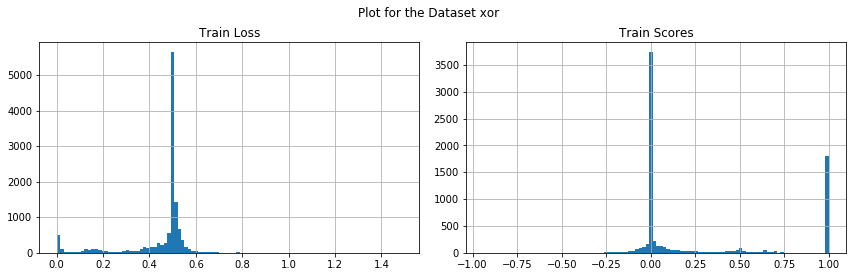

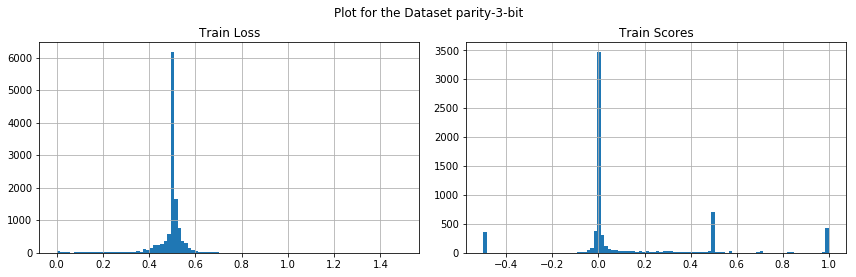

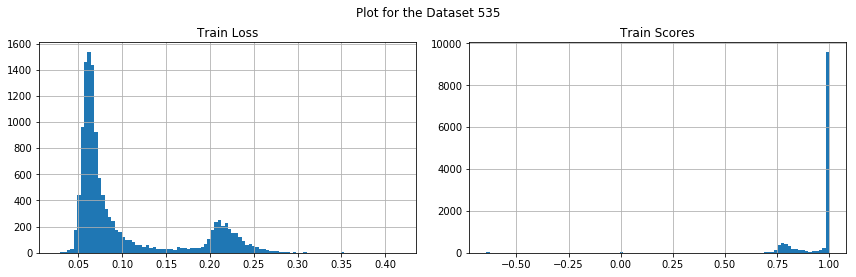

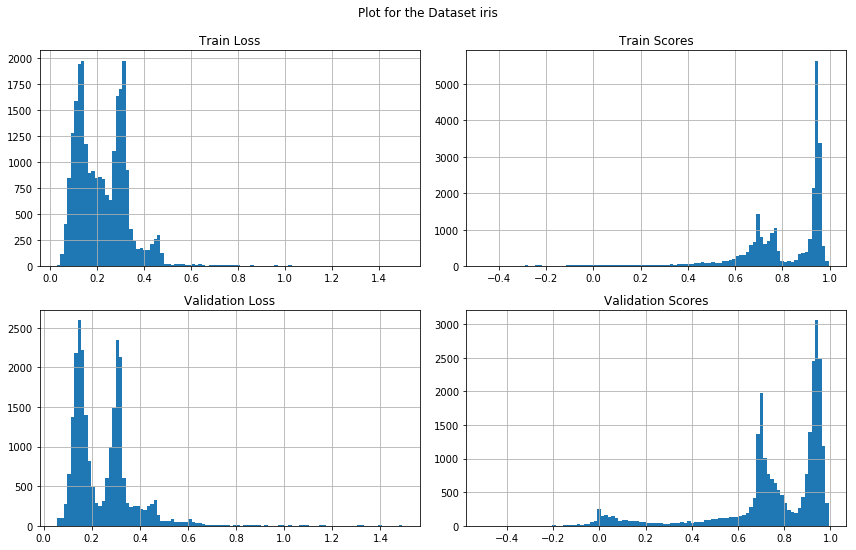

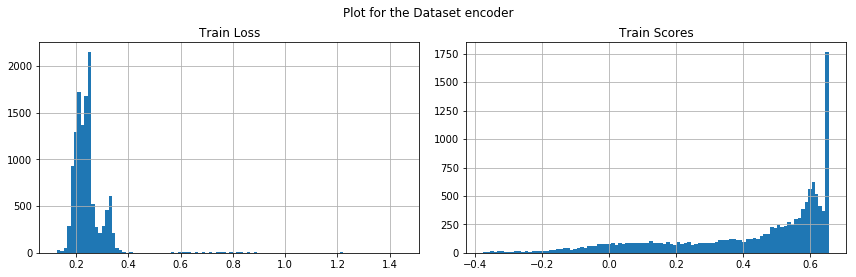

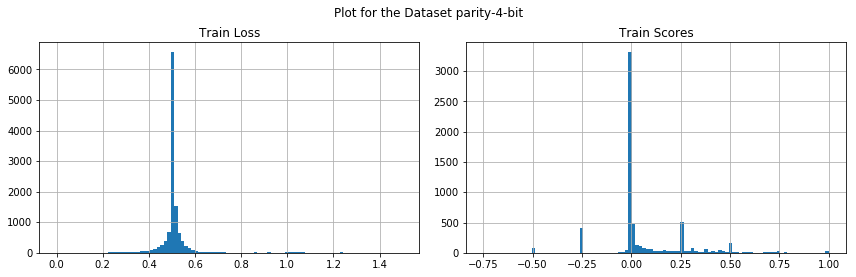

In [36]:
print('Metrics for Regression Tasks by Dataset')

for dataset in datasets:
    plot(df[using_regression & (df['dataset'] == dataset)], thresholds=(1.5, -1, 1.5, -1))

## Analysis of Regression Models Without ReLU Activation
- Some anomalous data points have been removed, however the data seems to tell the same story as before.

Metrics for Regression Tasks Not Using ReLU by Dataset


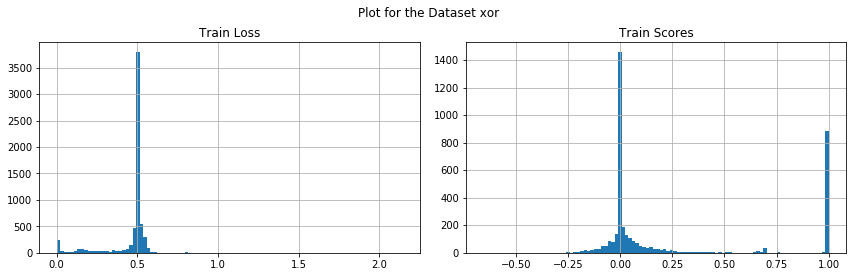

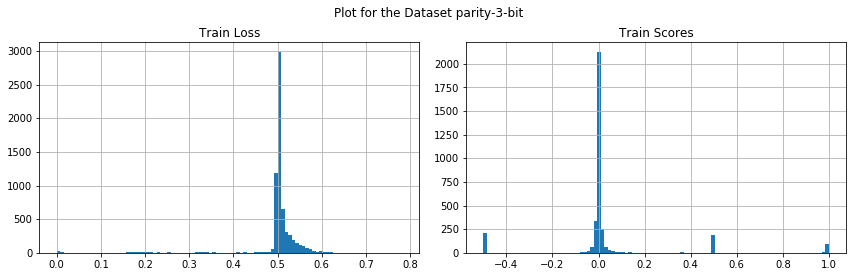

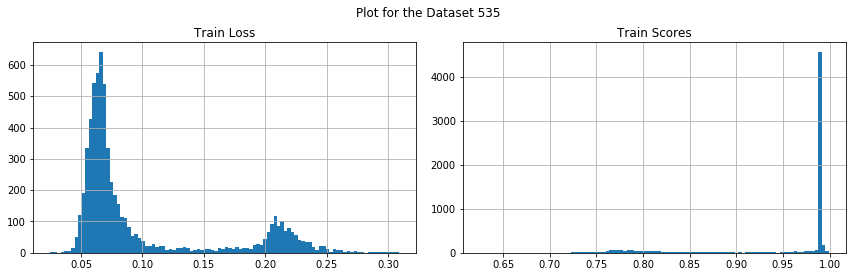

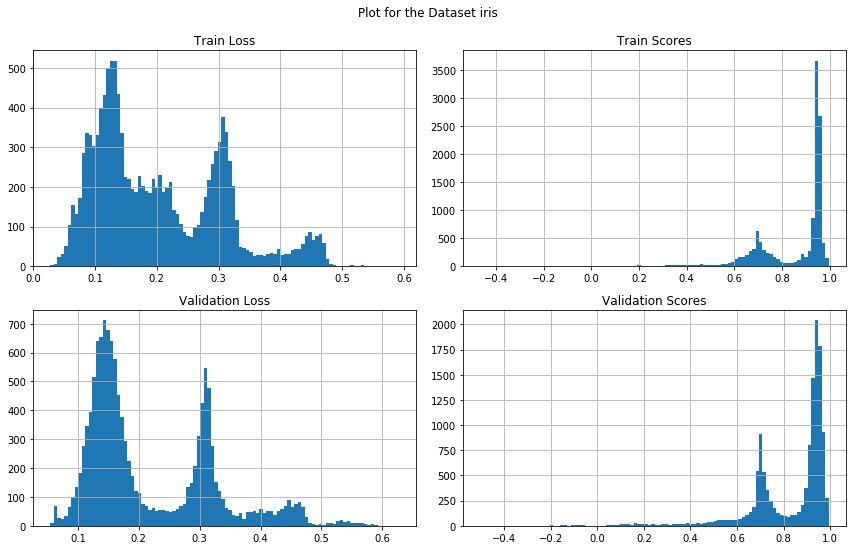

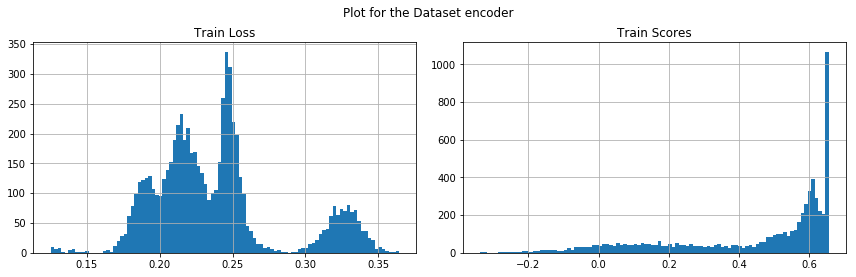

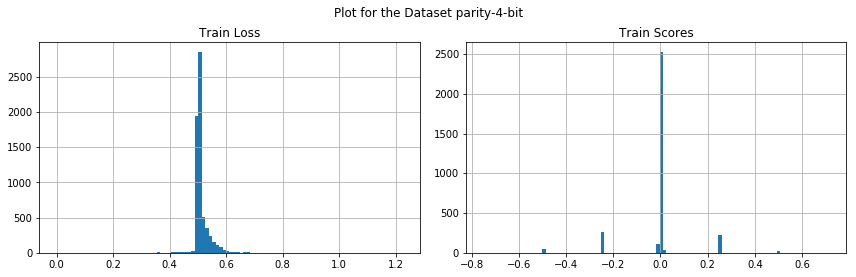

In [37]:
print('Metrics for Regression Tasks Not Using ReLU by Dataset')

for dataset in datasets:
    plot(df[~using_relu & using_regression & (df['dataset'] == dataset)], thresholds=(2.5, -1, 2.5, -1))

In [58]:
def plot_hue(masked_df, hue, thresholds=(10, -1, 10, -1)):
    """Plot the train loss, train scores, validation loss, and validation scores of a masked dataframe.
    
    :param masked_df: A dataframe that is masked for at least dataset.
    :param hue: The column that will be used to separate the data into groups. For example, 'clf_type' would
        separate the data into two sets for 'MLPRegressor' and 'MLPClassifier'.
    :param thresholds: A 4-tuple of threshold that the [train loss/train scores/validation loss/validation scores]
        must be [lower/higher/lower/higher] than to be plotted, respectively.
    """
    datasets = masked_df['dataset'].unique()
    dataset = datasets[0] if len(datasets) == 1 else None
    
    assert hue == 'dataset' or len(datasets) == 1, 'You can only plot one dataset at a time!'
    
    t = thresholds
    
    if dataset == 'iris':
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        axes = axes.ravel()
    else:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4), squeeze=True)
        
    groups = [group for group in masked_df[hue].unique()]
    train_loss_series = []
    train_score_series = []
    validation_loss_series = []
    validation_score_series = []
    
    for group in groups:
        df = masked_df[masked_df[hue] == group]
        
        # Data Wrangling    
        stacked_train_loss = pd.Series(df[df[train_loss_cols] < t[0]][train_loss_cols].values.ravel())    

        stacked_train_scores = pd.Series(df[df[train_scores_cols] > t[1]][train_scores_cols].values.ravel()) 

        stacked_val_loss = pd.Series(df[df[val_loss_cols] < t[2]][val_loss_cols].values.ravel()) 

        stacked_val_scores = pd.Series(df[df[val_scores_cols] > t[3]][val_scores_cols].values.ravel())
        
        train_loss_series.append(stacked_train_loss)
        train_score_series.append(stacked_train_scores)
        validation_loss_series.append(stacked_val_loss)
        validation_score_series.append(stacked_val_scores)

        
    axes[0].hist(train_loss_series, bins=100, stacked=True, label=groups)
    axes[0].set_title('Train Loss')

    axes[1].hist(train_score_series, bins=100, stacked=True, label=groups)
    axes[1].set_title('Train Scores')

    if dataset == 'iris':
        axes[2].hist(validation_loss_series, bins=100, stacked=True, label=groups)
        axes[2].set_title('Validation Loss')

        axes[3].hist(validation_score_series, bins=100, stacked=True, label=groups)
        axes[3].set_title('Validation Scores')

    axes[-1].legend(title=str(hue).capitalize(), 
                    loc='center left', bbox_to_anchor=(1, 0.5), 
                    fancybox=True, shadow=True)
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    title = 'Plot of Metrics by %s' % str(hue).capitalize()
    
    if dataset:
        title = title + ' for Dataset %s' % dataset
    
    fig.suptitle(title)

## Analysis of Regression Models by Dataset
- These plots seem to confirm that the MLP models struggled with the XOR, parity-3-bit, and the parity-4-bit datasets. However, the reasons why they struggled are still not clear.

Metrics for Regression Tasks by Dataset


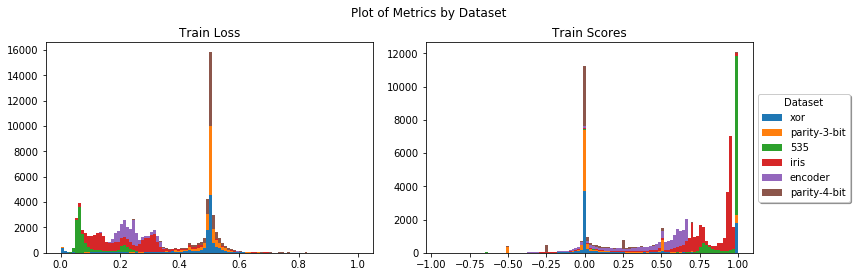

In [62]:
plot_hue(df[using_regression], hue='dataset', thresholds=(1.0, -1, 2.5, -1))

## Analysis of Regression Models by Activation Function
- Interestlingly enough, it seems my hypothesis about the ReLU being the main suspect for the high fail rates of the models is unfounded, and incorrect. Most cases, by a small margin, where the models failed to converge seems to be where the sigmoid activation was used.
- It seems that activation function alone is not related to the high fail rates.

Metrics for Regression Tasks by Activation Function


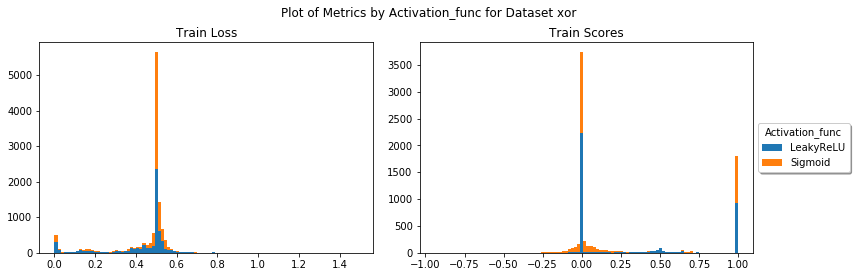

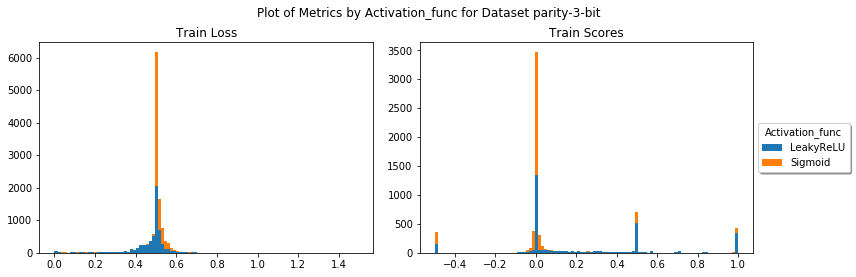

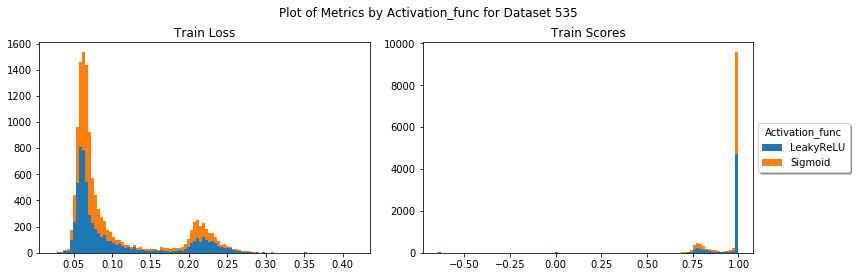

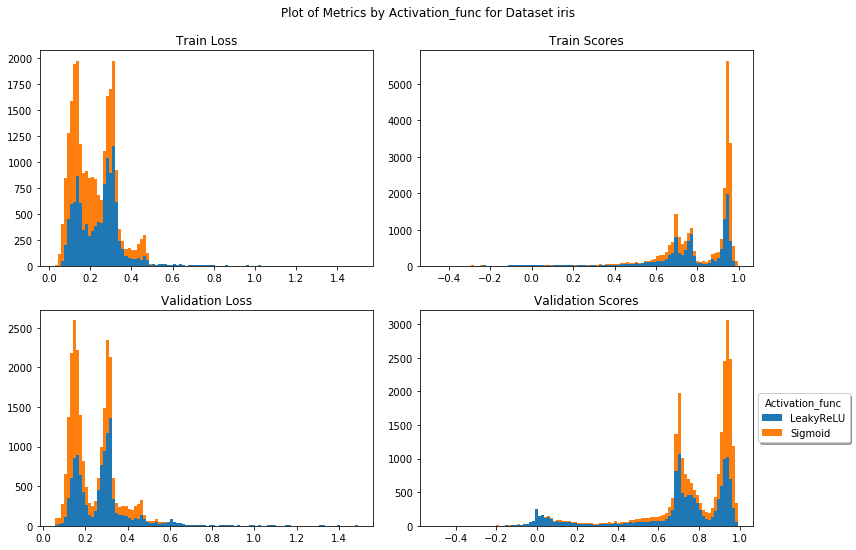

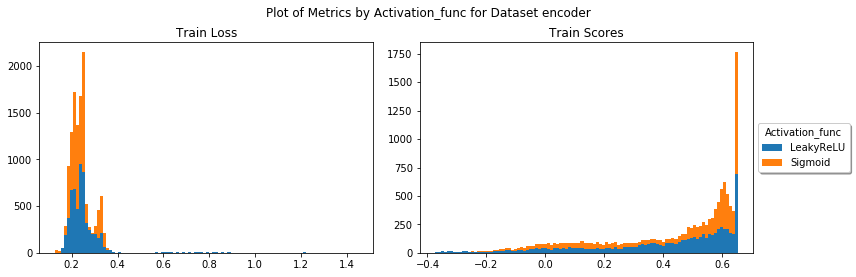

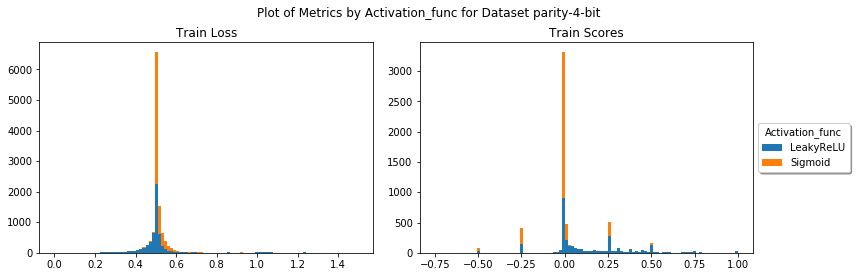

In [64]:
for dataset in datasets:
    plot_hue(df[using_regression & (df['dataset'] == dataset)], 
             hue='activation_func', thresholds=(1.5, -1, 1.5, -1))
    plt.show()

## Analysis of Regression Models by Batch Size
- The first thing that you may notice is that the training scores for $batch\_size=1$ are missing. 
  I had thought that by adding a small value $\epsilon$ to the denominator of the PCC I would have got zero, or near zero, training scores occaisionally.
- It would seem that the configurations with $batch\_size=1$ have conveniently omitted invalid scores :)
- However, my other hypothesis for the cause of the high fail rates is now proven to be wrong. The plot thickens...

Metrics for Regression Tasks by Batch Size


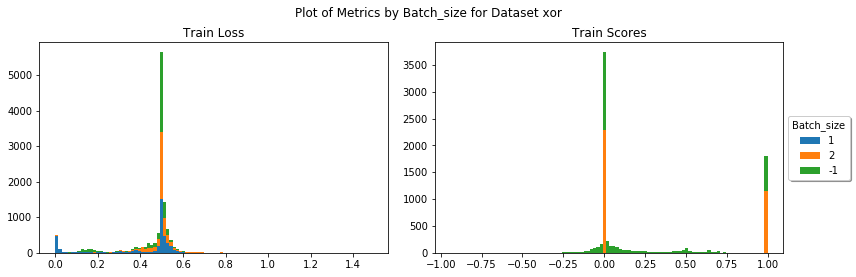

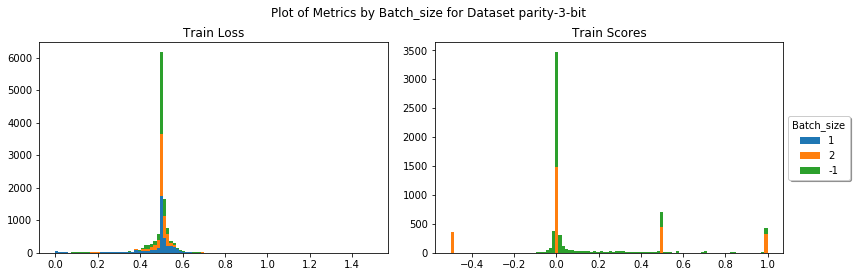

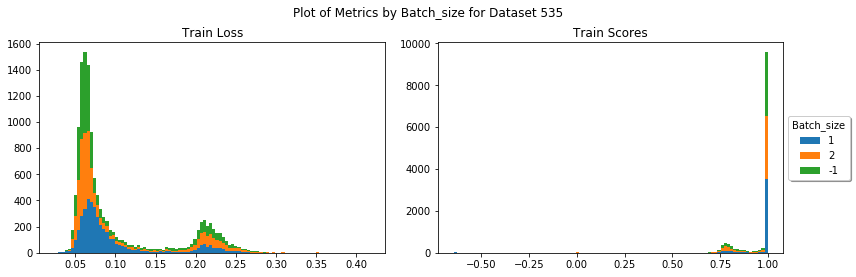

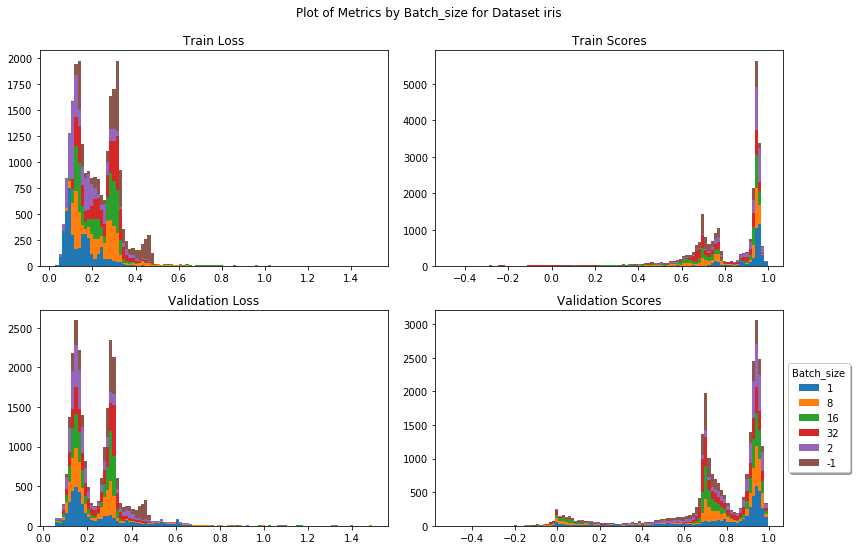

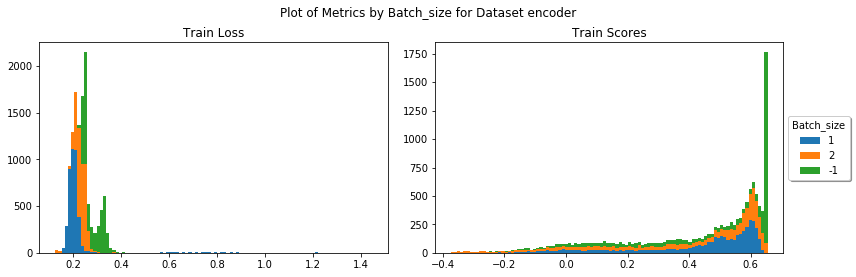

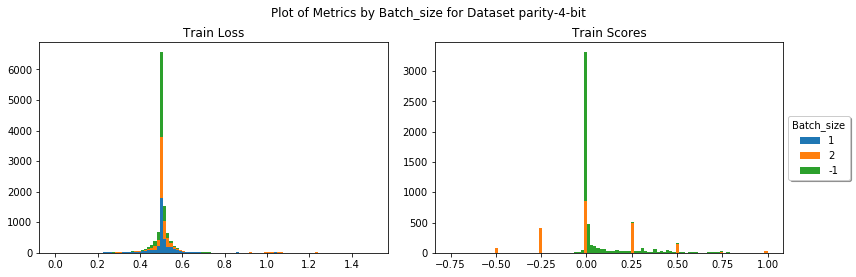

In [65]:
for dataset in datasets:
    plot_hue(df[using_regression & (df['dataset'] == dataset)], 
             hue='batch_size', thresholds=(1.5, -1, 1.5, -1))
    plt.show()

## Analysis of Regression Models by Gaussian Noise
- Again, no clear indication of what is causing the high fail rates. Perhaps it is a specific combination of hyperparameters that had a high fail rate?
- It seems that adding noise to the inputs benefitted the models trained on the iris dataset the most. This seems
  reasonable since the other problems had binary input/output spaces.

Metrics for Regression Tasks by Gaussian Noise


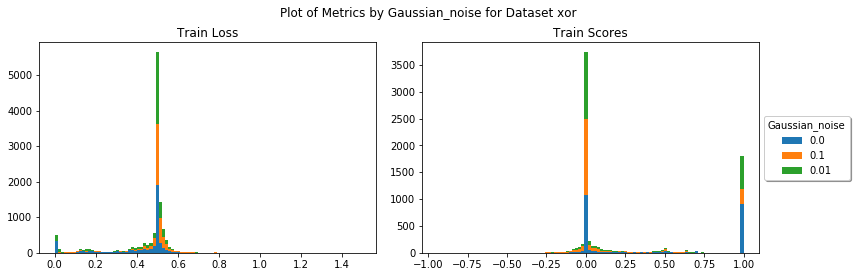

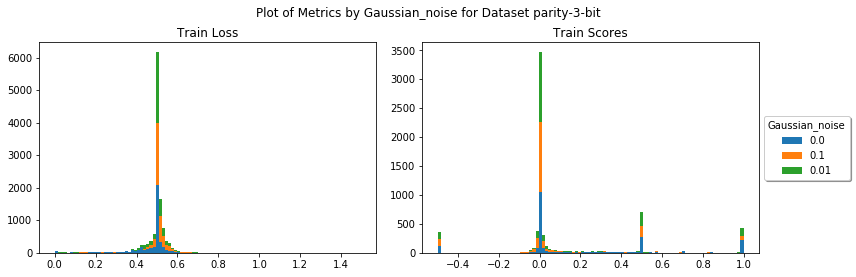

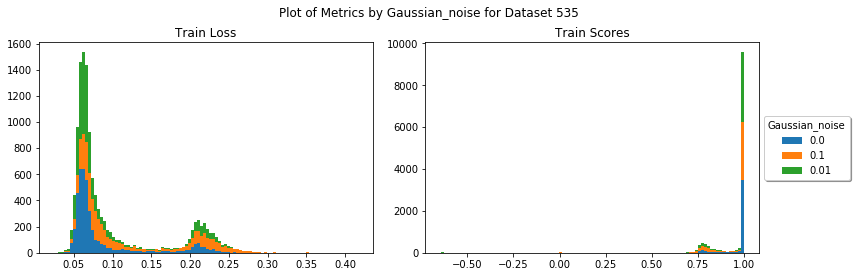

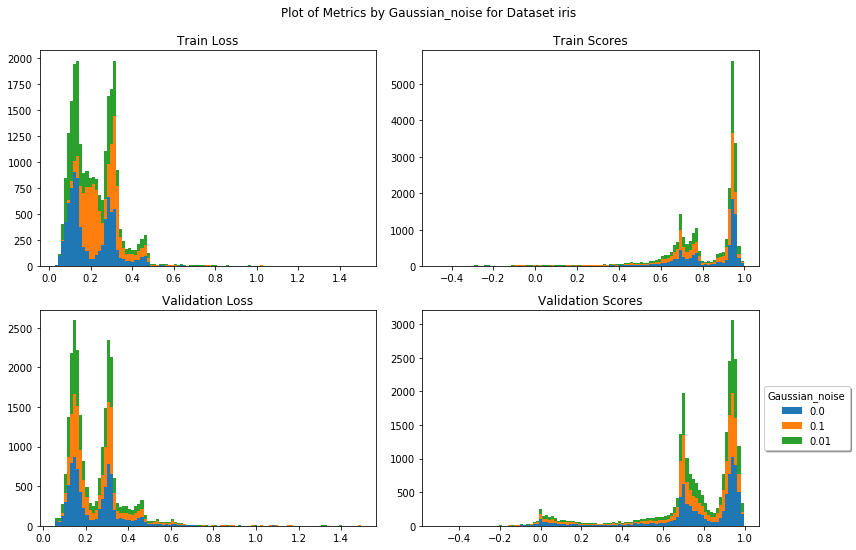

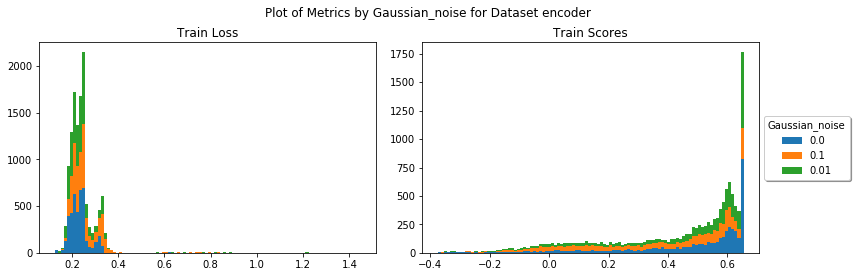

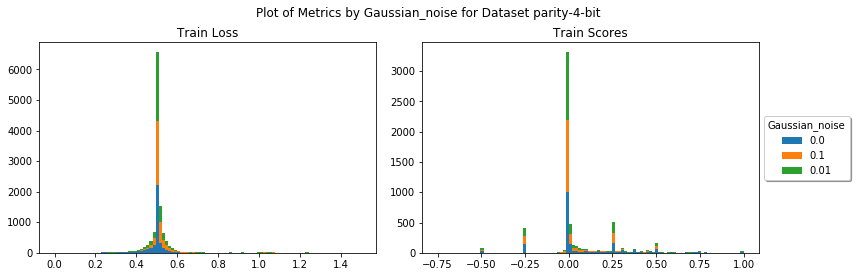

In [66]:
for dataset in datasets:
    plot_hue(df[using_regression & (df['dataset'] == dataset)], 
             hue='gaussian_noise', thresholds=(1.5, -1, 1.5, -1))
    plt.show()

## Analysis of Regression Models by Learning Rate
- Same story as above.
- It seems that a learning rate of 0.01 performs the best.

Metrics for Regression Tasks by Learning Rate


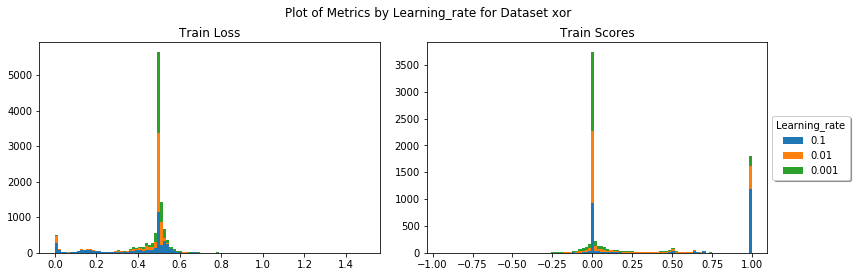

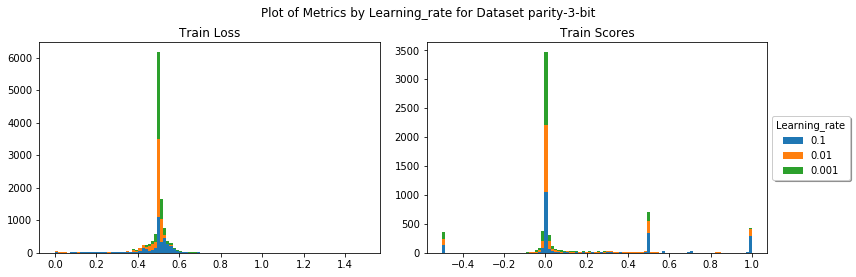

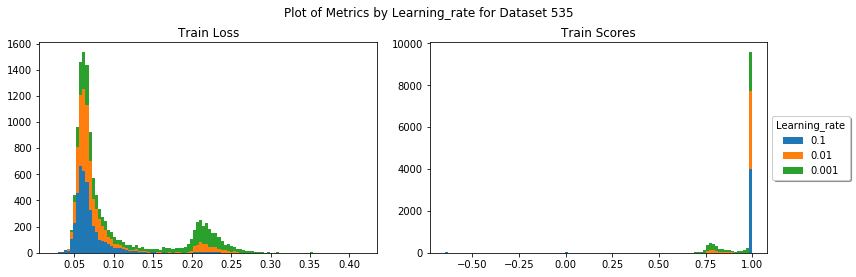

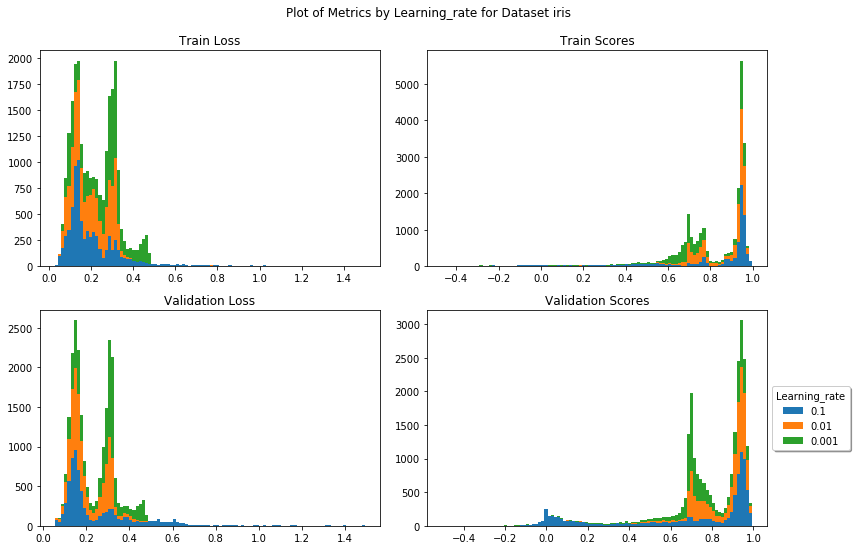

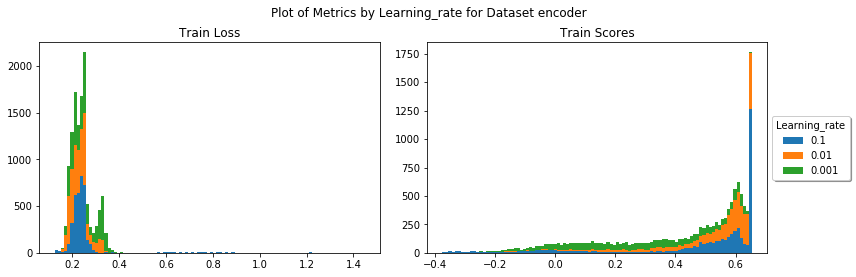

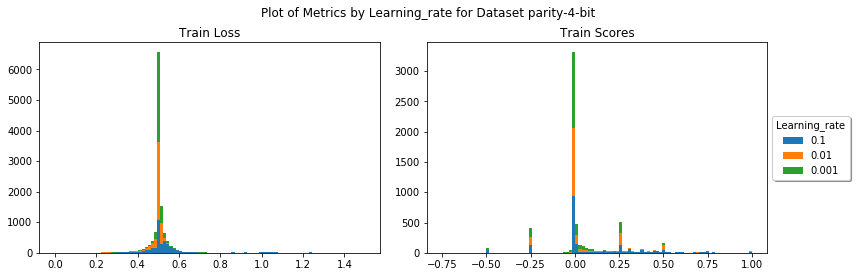

In [67]:
for dataset in datasets:
    plot_hue(df[using_regression & (df['dataset'] == dataset)], 
             hue='learning_rate', thresholds=(1.5, -1, 1.5, -1))
    plt.show()

## Analysis of Regression Models by Momentum
- Same story as above.

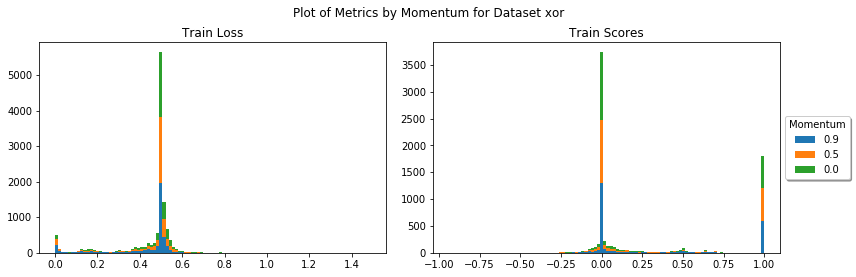

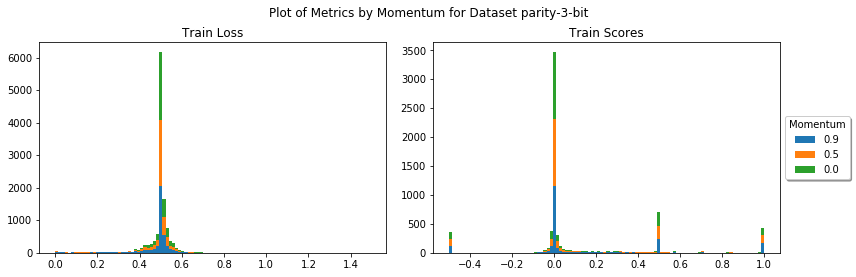

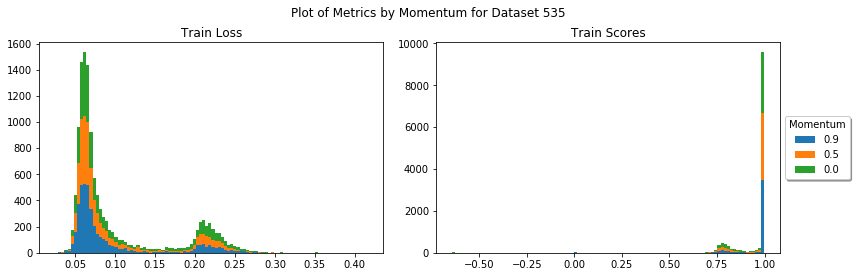

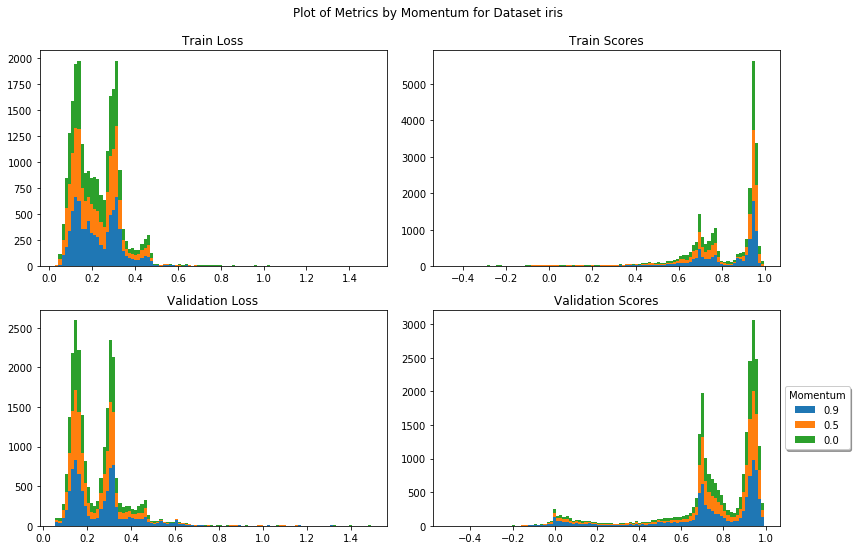

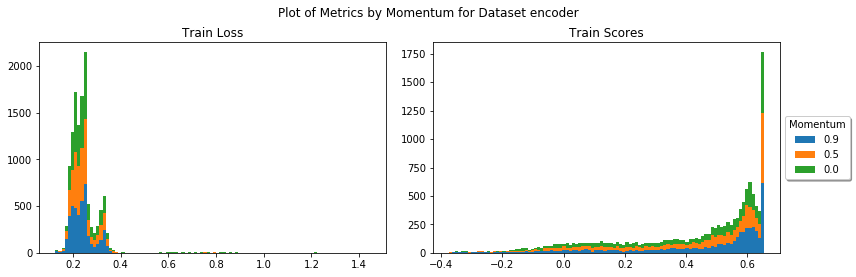

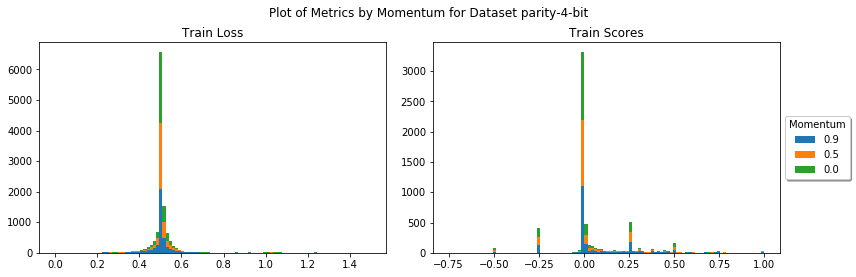

In [68]:
for dataset in datasets:
    plot_hue(df[using_regression & (df['dataset'] == dataset)], 
             hue='momentum', thresholds=(1.5, -1, 1.5, -1))
    plt.show()

## Analysis of Regression Models by Batch Shuffling
- Again, same story as above. I think that this confirms that there must be some combination of hyperparameters that is causing the spike of training scores of zero.

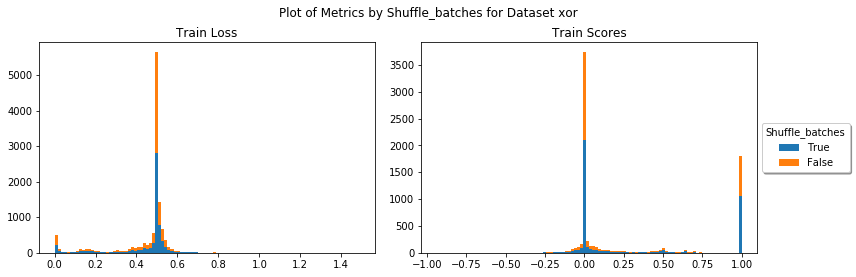

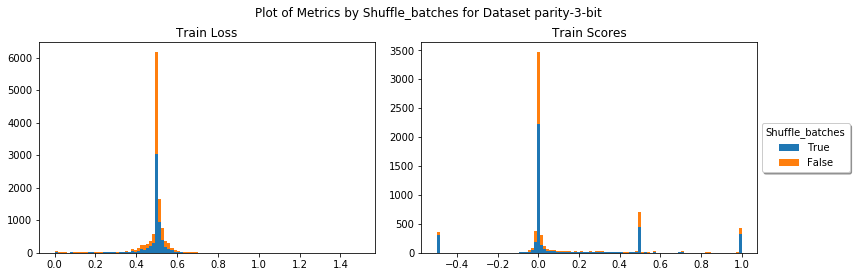

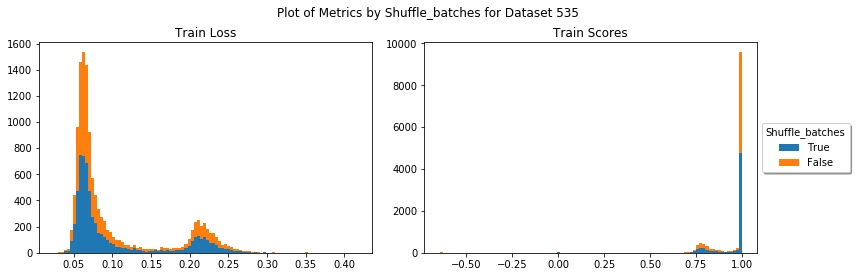

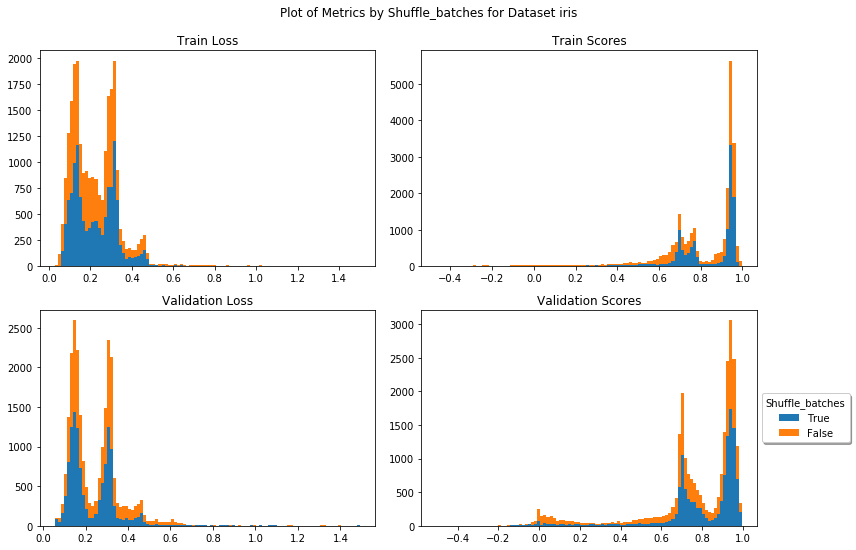

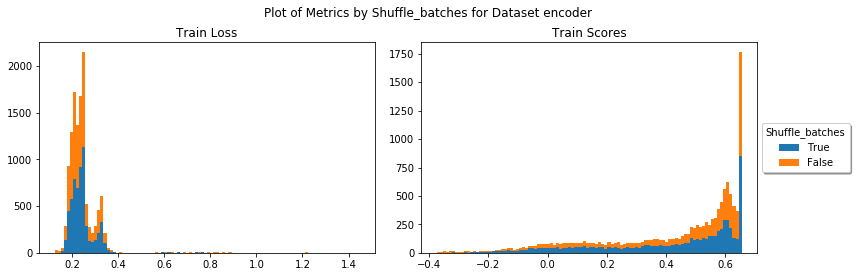

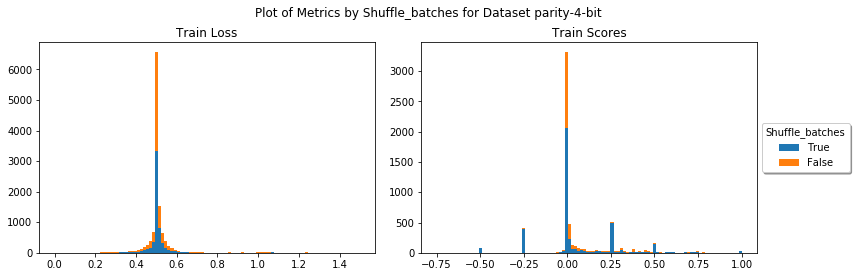

In [69]:
for dataset in datasets:
    plot_hue(df[using_regression & (df['dataset'] == dataset)], 
             hue='shuffle_batches', thresholds=(1.5, -1, 1.5, -1))
    plt.show()

## Are There High Failure Rates in Classification Models?
- Not really, however the peaks have shifted from 0.0 to 0.5 (still right in the middle though). However, it sill
  follows the same pattern. Perhaps it is something intrinsic to the datasets and/or how these datasets were tested?

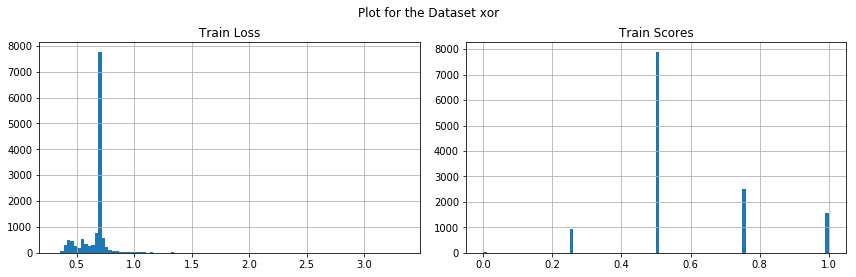

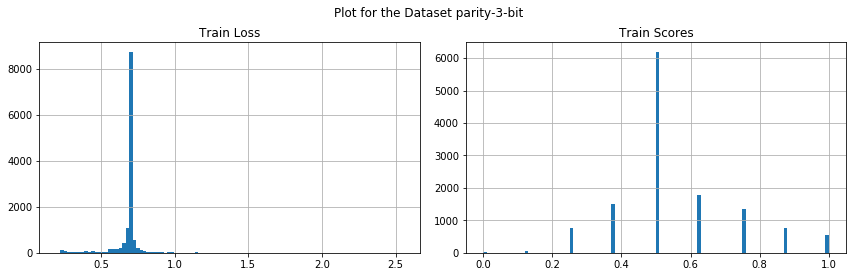

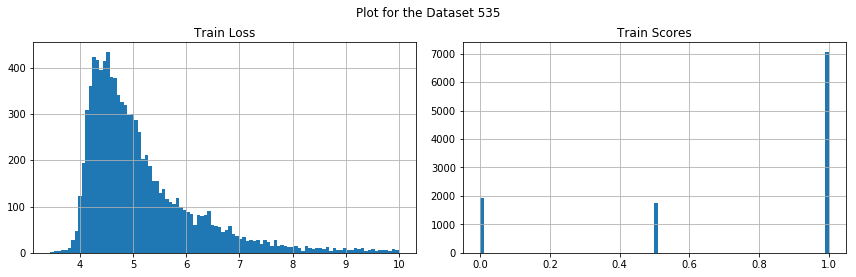

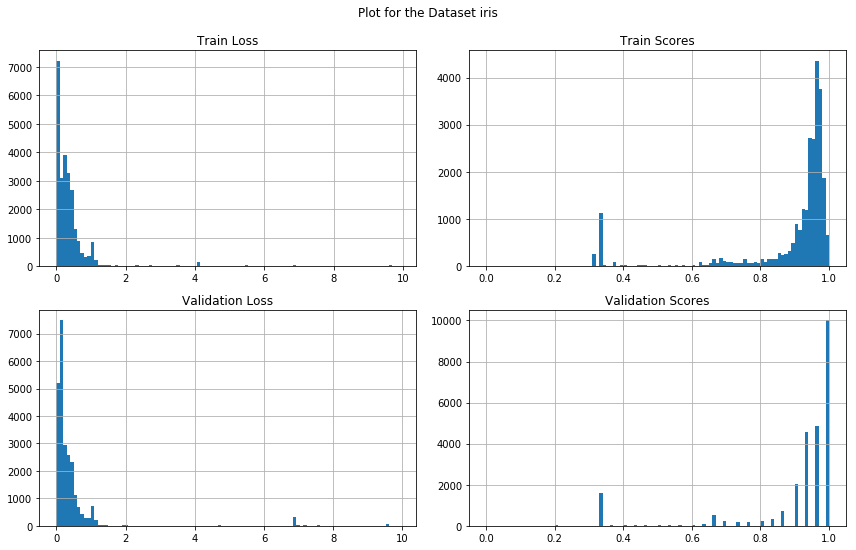

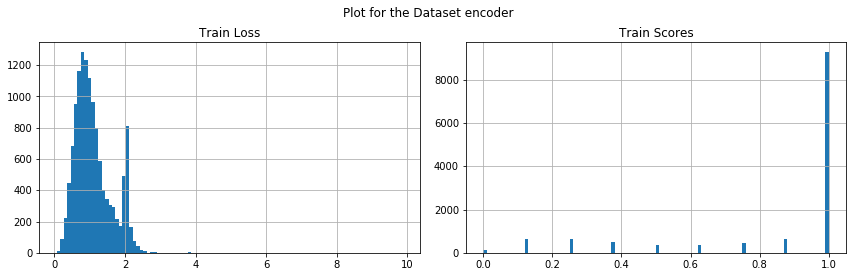

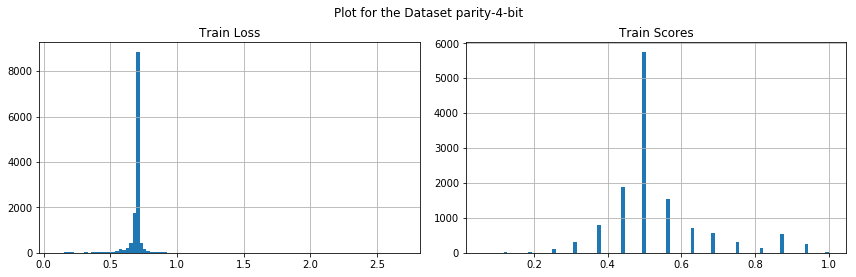

In [90]:
for dataset in datasets:
    plot(df[~using_regression & (df['dataset'] == dataset)], 
         thresholds=(10, -1, 10, -1))
    plt.show()